## LRP

In [1]:
# Biblioteki

from PIL import Image
import torchvision.transforms as transforms
import torch

from zennit.rules import Epsilon
from zennit.composites import EpsilonPlusFlat, EpsilonAlpha2Beta1Flat, DeconvNet, GuidedBackprop, BetaSmooth, ExcitationBackprop
from zennit.attribution import Gradient

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from dataclasses import dataclass
from typing import Callable
from scipy.stats import pearsonr


from util.cnn_parameters import IMG_HEIGHT, IMG_WIDTH, TEST_IMAGES_PATH, TRAIN_IMAGES_PATH
from util.torch_architecture import CNN
from zennit.image import imgify, imsave


INPUT_IMG_FILE = "input.png"
RELEVANCE_IMG_FILE = "relevance.png"


### Załadowanie modelu


In [2]:
model = CNN()
model.load_state_dict(torch.load("cats_dogs_cnn.pth", map_location=torch.device("cpu")))
model.eval()

C:\Users\magma\AppData\Local\Temp\ipykernel_29604\529079767.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cats_dogs_cnn.pth", map_loc

CNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Conv2d(128, 256, kernel_size=(3, 3), stride=

### Image Preprocessing

In [3]:

def prepare_image(image_path):

    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
        transforms.ToTensor(),
    ])

    input_image = transform(image).unsqueeze(0)

    # print("Input image shape:", input_image.shape)  # [1, 3, 128, 128]
    return input_image


### LRP

In [4]:
# Metoda LRP
def LRP_method(pytorch_model, input_image, composite = EpsilonAlpha2Beta1Flat(epsilon=1e-6)): #EpsilonPlusFlat(epsilon=1e-6)

    pytorch_model.eval()

    with Gradient(pytorch_model, composite=composite) as attributor:
        output, relevance = attributor(input_image)

    return output,  relevance

def plot_lrp(input_image, relevance):
    for _, inp in enumerate(input_image):
        imsave(INPUT_IMG_FILE, inp.detach())

    absrel = relevance.abs().sum(1)
    imsave(RELEVANCE_IMG_FILE, absrel[0], vmin=0, vmax=absrel[0].amax())
    image = imgify(absrel[0], vmin=0, vmax=absrel[0].amax())

    image1 = mpimg.imread(INPUT_IMG_FILE)
    image2 = mpimg.imread(RELEVANCE_IMG_FILE)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[0].set_title("Original Image")

    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[1].set_title("LRP Heatmap")

    plt.tight_layout()
    plt.show()

    os.remove(INPUT_IMG_FILE)
    os.remove(RELEVANCE_IMG_FILE)



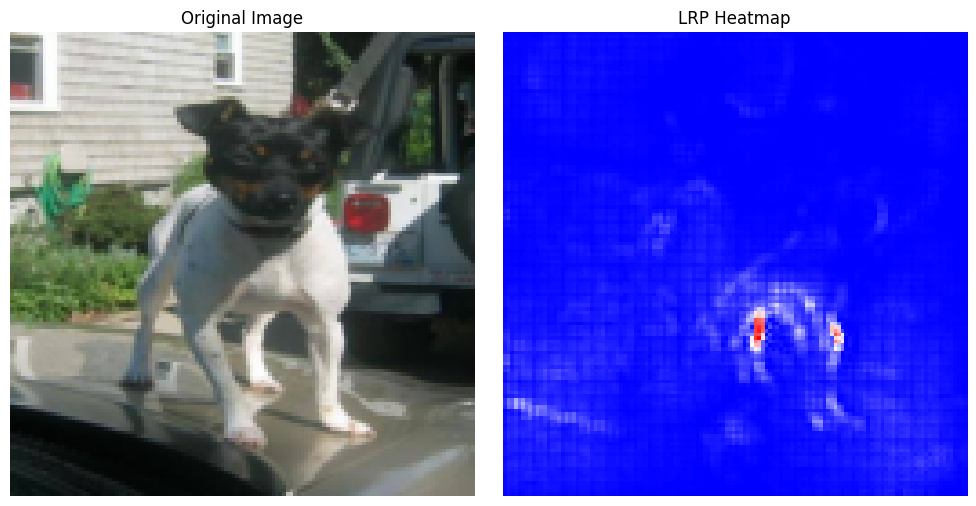

In [5]:
image_path = TEST_IMAGES_PATH + "\\77.jpg"
input_image = prepare_image(image_path)

output, relevance = LRP_method(model, input_image, composite = EpsilonAlpha2Beta1Flat(epsilon=1e-6)) #composite = EpsilonAlpha2Beta1Flat(epsilon=1e-6)

plot_lrp(input_image, relevance)

### Metrics

In [6]:
# Metrics utils

DAUC = "DAUC"
IAUC = "IAUC"
DELETION = "Deletion"
INSERTION = "Insertion"

@dataclass
class CorrMetricsParams:
    perturbed_image: Callable
    mask: Callable
    label: str


def cloned_image(input_image):
    return input_image.clone()

def zeros_image(input_image):
    return torch.zeros_like(input_image)

def mask_set_zero(abs_relevance, num_remove, sorted_indices):
    mask = torch.ones_like(abs_relevance.view(-1))
    mask[sorted_indices[:num_remove]] = 0  # Set most relevant pixels to 0
    return mask

def mask_set_one(abs_relevance, num_add, sorted_indices):
    mask = torch.zeros_like(abs_relevance.view(-1))
    mask[sorted_indices[:num_add]] = 1  # Set most relevant pixels to 1
    return mask

del_corr = CorrMetricsParams(
    perturbed_image=cloned_image,
    mask=mask_set_zero,
    label="removed"
)

ins_corr = CorrMetricsParams(
    perturbed_image=zeros_image,
    mask=mask_set_one,
    label="added"
)

metrics_params = {
    DAUC: True,
    IAUC: False,
    DELETION: del_corr,
    INSERTION: ins_corr,
}

def apply_mask(input_image, mask, abs_relevance):
    mask = mask.view(abs_relevance.shape).unsqueeze(0).repeat(3, 1, 1)
    perturbed_image = input_image * mask
    return perturbed_image

def get_abs_relevance(relevance):
    return relevance.abs().sum(1)[0]

def get_num_pixels(input_image):
    return input_image.shape[2] * input_image.shape[3]


In [7]:

def compute_auc(model, input_image, output, relevance, auc, steps=10, plot=False):
    model.eval()

    abs_relevance = get_abs_relevance(relevance)
    sorted_indices = abs_relevance.view(-1).argsort(descending=metrics_params[auc])

    perturbed_image = cloned_image(input_image)
    perturbation_curve = []
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)
        mask = mask_set_zero(abs_relevance, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            output = model(perturbed_image)

        perturbation_curve.append(output.item())

    x_vals = np.linspace(0, 1, steps)
    auc_value = np.trapz(perturbation_curve, x_vals)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, perturbation_curve, marker='o', label="Score Drop")
        plt.xlabel("Fraction of pixels occluded")
        plt.ylabel("Model Output Score")
        plt.title(f"{auc} Evaluation (AUC = {auc_value:.4f})")
        plt.legend()
        plt.show()

    return auc_value, perturbation_curve

def compute_ins_del_correlation(model, input_image, output, relevance, corr, steps=10, plot=False):
    model.eval()

    abs_relevance = get_abs_relevance(relevance)
    sorted_indices = abs_relevance.view(-1).argsort(descending=True)

    perturbed_image = metrics_params[corr].perturbed_image(input_image)
    perturbation_curve = []
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)

        mask = metrics_params[corr].mask(abs_relevance, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            output = model(perturbed_image)

        perturbation_curve.append(output.item())

    x_vals = np.linspace(0, 1, steps)
    correlation, _ = pearsonr(x_vals, perturbation_curve)  # Pearson

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, perturbation_curve, marker='o', label="Score Drop")
        plt.xlabel(f"Fraction of pixels {metrics_params[corr].label}")
        plt.ylabel("Model Output Score")
        plt.title(f"{corr} Correlation = {correlation:.4f}")
        plt.legend()
        plt.show()

    return correlation

def compute_average_drop(model, input_image,output, relevance, steps=10, plot=False):
    model.eval()

    abs_relevance = get_abs_relevance(relevance)
    sorted_indices = abs_relevance.view(-1).argsort(descending=True)

    perturbed_image = cloned_image(input_image)
    drop_curve = []
    initial_output = model(input_image).item()
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)

        mask = mask_set_zero(abs_relevance, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            output = model(perturbed_image)

        drop = initial_output - output.item()
        drop_curve.append(drop)

    average_drop = np.mean(drop_curve)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(np.linspace(0, 1, steps), drop_curve, marker='o', label="Output Drop")
        plt.xlabel("Fraction of pixels removed")
        plt.ylabel("Drop in model output")
        plt.title(f"Average Drop = {average_drop:.4f}")
        plt.legend()
        plt.show()

    return average_drop

def compute_increase_in_confidence(model, input_image, output, relevance, steps=10, plot=False):

    model.eval()

    abs_relevance = get_abs_relevance(relevance)
    sorted_indices = abs_relevance.view(-1).argsort(descending=True)

    perturbed_image = zeros_image(input_image)
    confidence_curve = []
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_add = int((step / steps) * num_pixels)

        mask = mask_set_one(abs_relevance, num_add, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            output = model(perturbed_image)

        confidence = torch.sigmoid(output).item()
        confidence_curve.append(confidence)

    increase_in_confidence = confidence_curve[-1] - confidence_curve[0]

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(np.linspace(0, 1, steps), confidence_curve, marker='o', label="Confidence")
        plt.xlabel("Fraction of pixels added")
        plt.ylabel("Confidence (probability of positive class)")
        plt.title(f"Increase in Confidence = {increase_in_confidence:.4f}")
        plt.legend()
        plt.show()

    return increase_in_confidence



In [10]:
# For one example

iauc_value, curve = compute_auc(model, input_image, output, relevance, auc=IAUC,steps=10)
print(f"IAUC Score: {iauc_value:.4f}")

dauc_value, curve = compute_auc(model, input_image, output, relevance, auc=DAUC,steps=10)
print(f"DAUC Score: {dauc_value:.4f}")

insertion_correlation = compute_ins_del_correlation(model, input_image, output, relevance, corr=INSERTION,steps=10)
print(f"Insertion Correlation: {insertion_correlation:.4f}")

deletion_correlation = compute_ins_del_correlation(model, input_image, output, relevance, corr=DELETION,steps=10)
print(f"Deletion Correlation: {deletion_correlation:.4f}")

average_drop = compute_average_drop(model, input_image, output, relevance, steps=10)
print(f"Average Drop: {average_drop:.4f}")

increase_in_confidence = compute_increase_in_confidence(model, input_image, output, relevance, steps=10)
print(f"Increase in Confidence: {increase_in_confidence:.4f}")

C:\Users\magma\AppData\Local\Temp\ipykernel_29604\1886424182.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)


IAUC Score: 0.4208
DAUC Score: 0.3717
Insertion Correlation: 0.4227
Deletion Correlation: -0.5551
Average Drop: 0.5597
Increase in Confidence: 0.0944


### Batch metrics

In [ ]:

def get_output_relevance(input_images):
    outputs = []
    relevances = []
    for i in input_images:
        o, r = LRP_method(model, i)
        outputs.append(o)
        relevances.append(r)
    return outputs, relevances

def batch_dauc(input_images):
    outputs, relevances = get_output_relevance(input_images)

    dauc_values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        dauc_value, _ = compute_auc(model, input_image, output, relevance, auc=DAUC,steps=10)
        dauc_values.append(dauc_value)

    return np.mean(dauc_values)

def batch_iauc(input_images):
    outputs, relevances = get_output_relevance(input_images)

    iauc_values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        iauc_value, _ = compute_auc(model, input_image, output, relevance, auc=IAUC,steps=10)
        iauc_values.append(iauc_value)

    return np.mean(iauc_values)

def batch_inser_corr(input_images):
    outputs, relevances = get_output_relevance(input_images)

    corr_values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        corr_value = compute_ins_del_correlation(model, input_image, output, relevance, corr=INSERTION,steps=10)
        corr_values.append(corr_value)

    return np.mean(corr_values)

def batch_del_corr(input_images):
    outputs, relevances = get_output_relevance(input_images)

    corr_values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        corr_value = compute_ins_del_correlation(model, input_image, output, relevance, corr=DELETION,steps=10)
        corr_values.append(corr_value)

    return np.mean(corr_values)

def batch_avg_drop(input_images):
    outputs, relevances = get_output_relevance(input_images)

    values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        val = compute_average_drop(model, input_image, output, relevance, steps=10)
        values.append(val)

    return np.mean(values)

def batch_confidence_incr(input_images):
    outputs, relevances = get_output_relevance(input_images)

    values = []
    for input_image, output, relevance in zip(input_images, outputs, relevances):
        val = compute_increase_in_confidence(model, input_image, output, relevance, steps=10)
        values.append(val)

    return np.mean(values)

In [ ]:
NUM_IMAGES = 200
img_paths_for_metrics = [TEST_IMAGES_PATH + "\\" + str(i) + ".jpg" for i in range(1, NUM_IMAGES+1)]
input_images_for_metrics = [prepare_image(img_path) for img_path in img_paths_for_metrics]

print("Average DAUC: " + str(batch_dauc(input_images_for_metrics)))
print("Average IAUC: " + str(batch_iauc(input_images_for_metrics)))
print("Average Insertion Correlation: " + str(batch_inser_corr(input_images_for_metrics)))
print("Average Deletion Correlation: " + str(batch_del_corr(input_images_for_metrics)))
print("Average Average Drop: " + str(batch_avg_drop(input_images_for_metrics)))
print("Average Increase in Confidence: " + str(batch_confidence_incr(input_images_for_metrics)))


C:\Users\magma\AppData\Local\Temp\ipykernel_29604\1886424182.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_value = np.trapz(perturbation_curve, x_vals)


Average DAUC: 0.5468494352949266
Average IAUC: 0.3873822387412668
Average Insertion Correlation: 0.11861929401318787
Average Deletion Correlation: -0.24095774604542658
Average Average Drop: -0.0932832377047626
Average Increase in Confidence: 0.01375871777534485
